In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import orca
import time
import geopandas as gpd

In [8]:
hdf = pd.HDFStore('../output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  20002
Number of Persons:  49565
Number of tours:  66148
Number of trips:  169674


In [9]:
def car_ownership_validation(hh):
    ''' Validation tool for car ownership model
    Input: Dataframe with columns VEHCL: Real number of vehicles, 
           and 'auto_ownership': predicted household car ownership. 
    Output: Plots of carownership by TAZ. 
    '''
    # Auto ownership by TAZ 
    hh['0'] = hh['auto_ownership'] == 0
    hh['1'] = hh['auto_ownership'] == 1
    hh['2'] = hh['auto_ownership'] == 2
    hh['3'] = hh['auto_ownership'] == 3
    hh['4'] = hh['auto_ownership'] == 4

    auto_asim = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum' })
    auto_asim.reset_index(inplace = True)

    auto_asim = pd.melt(auto_asim, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    #VEHCL by TAZ 
    hh['0'] = hh['VEHICL'] == 0
    hh['1'] = hh['VEHICL'] == 1
    hh['2'] = hh['VEHICL'] == 2
    hh['3'] = hh['VEHICL'] == 3
    hh['4'] = hh['VEHICL'] >= 4

    auto_tm1 = hh.groupby('TAZ').agg({'0': 'sum','1': 'sum','2': 'sum','3': 'sum','4': 'sum', })
    auto_tm1.reset_index(inplace = True)

    auto_tm1 = pd.melt(auto_tm1, id_vars=['TAZ'], value_vars=['0', '1', '2', '3', '4'])
    
    # Merge ativitysim and validation results in one table
    auto = auto_asim.merge(auto_tm1, how = 'inner', on = ['TAZ', 'variable'], suffixes=('_asim', '_tm1'))
    auto.columns = ['TAZ', 'Auto ownership', 'ActivitySim', 'True value']
    
    #Plot
    g = sns.lmplot('True value','ActivitySim', auto,col = 'Auto ownership',sharex = False,sharey = False,
               markers='o', height=5, aspect=0.8, x_jitter=.1, col_wrap=3,
              scatter_kws={"s": 20, "edgecolor": 'k', "alpha": 0.5})

    g.fig.suptitle("H3-to-H3 Car ownerwhip \n ActivitySim", y=1.05, fontsize = 15);
    return auto

## Work Distances LODES

In [5]:
from activitysim.abm.models import initialize_from_usim as usim

In [6]:
zones = gpd.read_file('h3_hexbis.shp').set_index('TAZ')
orca.add_table('zones', zones);

In [ ]:
hdf = pd.HDFStore('model_data.h5')
blocks = hdf['/blocks']
orca.add_table('blocks', blocks);

In [ ]:
hdf.keys()

In [ ]:
@orca.column('blocks', cache = True)
def TAZ(blocks, zones):
    blocks_df = blocks.to_frame(columns = ['x', 'y'])
    h3_gpd =  zones.to_frame(columns = ['geometry', 'area'])
    return usim.assign_taz(blocks_df, h3_gpd)

In [23]:
url = 's3://austin-activitysim/base/tx_od_main_JT01_2015.csv'
lodes_ods = pd.read_csv(url, dtype={'w_geocode': str, 'h_geocode': str}, 
                        usecols=['w_geocode', 'h_geocode', 'S000'])

In [ ]:
orca.list_tables()

In [ ]:
from activitysim.core import config

In [ ]:
settings = {'usim_data_store':'model_data.h5', 'usim_zone_geoms':'h3'}

In [2]:
from activitysim.core import config
from activitysim.core import inject
from activitysim.core import pipeline

inject.add_injectable('data_dir', '/')
inject.add_injectable('configs_dir', ['configs', '../configs/configs'])
inject.add_injectable('output_dir', '/')

In [ ]:
pipeline.close_pipeline()

In [3]:
pipeline.run(models=['load_usim_data'])

Opening /pipeline.h5 in read-only mode


OSError: ``/pipeline.h5`` does not exist

In [ ]:
import logging

from activitysim.core import mem
from activitysim.core import inject
from activitysim.core import tracing
from activitysim.core import config
from activitysim.core import pipeline
from activitysim.core import mp_tasks
from activitysim.core import chunk

logger = logging.getLogger('activitysim')

inject.add_injectable('data_dir', '/')
inject.add_injectable('configs_dir', ['configs', '../configs/configs'])
inject.add_injectable('output_dir', 'data')

def run():
    
    # Create a new skims.omx file from BEAM (http://beam.lbl.gov/) skims
    # if skims do not already exist in the input data directory
    if config.setting('create_skims_from_beam'):
        pipeline.run(models=['create_skims_from_beam'])
        pipeline.close_pipeline()   

    # Create persons, households, and land use .csv files from UrbanSim
    # data if these files do not already exist in the input data directory
    if config.setting('create_inputs_from_usim_data'):
        pipeline.run(models=['load_usim_data'])
        pipeline.close_pipeline()


run()


In [ ]:
usim.load_usim_data('',settings)

In [ ]:
import orca

In [ ]:
orca.list_tables()

In [ ]:
%%time
blocks = orca.get_table('usim_households').to_frame()

# Mode choice 

## Work trips

In [10]:
path = 's3://austin-activitysim/base/A302103 - Means of transportation (18) (Workers 16 years and over).csv'
ctpp_ms = pd.read_csv(path)

In [11]:
modes_ctpp = {'Car, truck, or van -- Drove alone': 'Car',
         'Car, truck, or van -- In a 2-person carpool': 'Car',
         'Car, truck, or van -- In a 3-person carpool': 'Car',
         'Car, truck, or van -- In a 4-person carpool': 'Car',
         'Car, truck, or van -- In a 5-or-6-person carpool': 'Car',
         'Car, truck, or van -- In a 7-or-more-person carpool': 'Car',
         'Bus or trolley bus': 'Bus', 
         'Streetcar or trolley car': 'Bus',
         'Subway or elevated': 'heavy rail', 
         'Railroad' : 'other', 
         'Ferryboat': 'other', 
         'Bicycle': 'Bike', 
         'Walked': 'Walk',
         'Taxicab': 'other',
         'Motorcycle': 'other',
         'Other method':'other'}

ctpp_ms['ctpp_mode'] = ctpp_ms['Means of Transportation 18'].replace(modes_ctpp)
ctpp_ms.dropna(inplace = True)
ctpp_ms['Workers 16 and Over'] = ctpp_ms['Workers 16 and Over'].astype(int)

mode_share_ctpp = ctpp_ms.groupby('ctpp_mode').sum()
mode_share_ctpp.reset_index(inplace = True)
mask_mode = ~mode_share_ctpp.ctpp_mode.isin(['Auto','Total, means of transportation', 'Worked at home'])
mode_share_ctpp = mode_share_ctpp[mask_mode]
mode_share_ctpp['suma'] = mode_share_ctpp['Workers 16 and Over'].sum()
mode_share_ctpp['mode_share'] = mode_share_ctpp['Workers 16 and Over']/mode_share_ctpp['suma']

In [12]:
modes_asim = {'WALK_LRF': 'other', 
              'WALK_LOC': 'Bus', 
              'SHARED3FREE': 'Car', 
              'WALK_COM': 'other',
              'DRIVEALONEFREE': 'Car', 
              'SHARED2FREE':'Car', 
              'BIKE': 'Bike', 
              'DRIVE_LRF': 'other',
              'WALK': 'Walk',
              'WALK_HVY':'heavy rail', 
              'WALK_EXP':'Bus', 
              'DRIVE_LOC': 'Bus', 
              'DRIVE_HVY':'heavy rail', 
              'DRIVE_COM':'other',
              'DRIVEALONEPAY':'Car', 
              'SHARED2PAY':'Car', 
              'DRIVE_EXP': 'Bus',
              'SHARED3PAY':'Car'}

tours['ctpp_mode'] = tours.tour_mode.replace(modes_asim)
tours_work = tours[tours.tour_type == 'work'] # just work trips

mode_share_asim_work = pd.DataFrame(tours_work.groupby('ctpp_mode')['person_id'].count())
mode_share_asim_work['suma'] = mode_share_asim_work['person_id'].sum()
mode_share_asim_work['mode_share'] = mode_share_asim_work['person_id']/mode_share_asim_work['suma'] 
mode_share_asim_work.reset_index(inplace = True)

In [13]:
mode_share_asim_work['model'] = 'Activity Sim'
mode_share_ctpp['model'] = 'CTPP'
join = pd.concat([mode_share_asim_work, mode_share_ctpp])

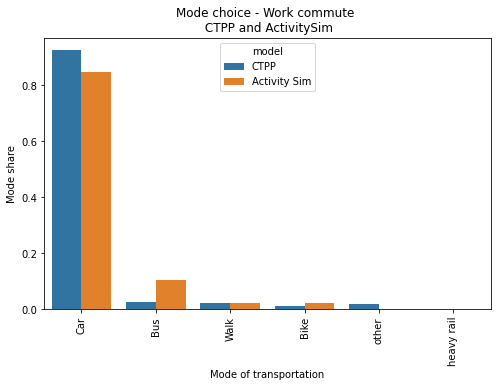

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x='ctpp_mode', y='mode_share', hue = 'model', data = join.sort_values('mode_share', ascending=False))
plt.xticks(rotation = 90)
plt.title('Mode choice - Work commute \n CTPP and ActivitySim')
plt.ylabel('Mode share')
plt.xlabel('Mode of transportation');

## All trips

In [15]:
modes_asim = {'WALK_LRF': 'walk_transit', 
              'WALK_LOC': 'walk_transit', 
              'SHARED3FREE': 'car', 
              'WALK_COM': 'walk_transit',
              'DRIVEALONEFREE': 'car', 
              'SHARED2FREE':'car', 
              'BIKE': 'bike', 
              'DRIVE_LRF': 'drive_transit',
              'WALK': 'walk',
              'WALK_HVY':'walk_transit', 
              'WALK_EXP':'walk_transit', 
              'DRIVE_LOC': 'drive_transit', 
              'DRIVE_HVY':'drive_transit', 
              'DRIVE_COM':'drive_transit',
              'DRIVEALONEPAY':'car', 
              'SHARED2PAY':'car', 
              'DRIVE_EXP': 'drive_transit',
              'SHARED3PAY':'car'}

tours['asim_mode'] = tours.tour_mode.replace(modes_asim)

mode_share_asim = pd.DataFrame(tours.groupby('asim_mode')['person_id'].count())
mode_share_asim['total'] = mode_share_asim['person_id'].sum()
mode_share_asim['mode_share'] = mode_share_asim['person_id']/mode_share_asim['total'] 
mode_share_asim.reset_index(inplace = True)

In [18]:
def mode_choice_validation(tour_mode):
    ''' Validate mode shares'''
    
    #Results activitysim 
    pct = tour_mode.value_counts()/tour_mode.count()
    asim = pd.DataFrame(pct).reset_index()
    asim.columns = ['mode', 'share']
    asim['model'] = 'ActivitySim'
    
    # Real values
#     real_shares = pd.DataFrame({'mode':['car', 'walk', 'bike', 'ride_hail', 
#                        'ride_hail_transit', 'walk_transit', 
#                        'drive_transit', 'ride_hail_pooled'], 
#                       'share': [0.8455, 0.0868, 0.0125, 0.0113,
#                              0.0019, 0.0329, 0.0035, 0.0056] })
    #assuming: Raid_hail options: car. and ride_hail_transit == drive)_transit
    real_shares = pd.DataFrame({'mode':['car', 'walk', 'bike', 'walk_transit', 'drive_transit'], 
                      'share': [0.8624, 0.0868, 0.0125, 0.0329, 0.0054] })
    assert real_shares.share.sum() == 1
    real_shares['model'] = 'Real mode share'
    
    
    results = pd.concat((asim,real_shares), axis = 0)
    
    #plotting 
    fig, ax = plt.subplots(figsize = (8,5))
    sns.barplot(x='mode', y='share', hue = 'model', data = results.sort_values('share', ascending=False))
    plt.xticks(rotation = 90)
    plt.title('Mode choice - Mode shares')
    plt.ylabel('Mode share - log Scale')
    plt.xlabel('Mode of transportation')
#     plt.yscale('log')
    plt.legend(loc = 'upper right')
    return asim;

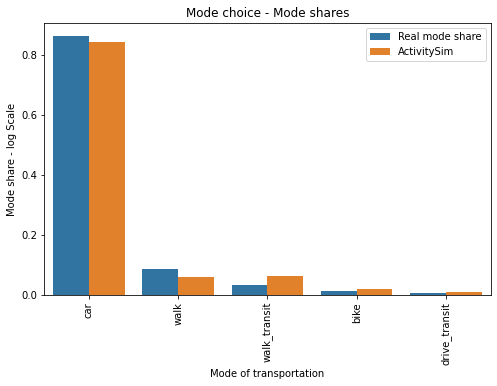

In [19]:
asim = mode_choice_validation(tour_mode = tours['asim_mode'])

In [20]:
a = asim.sort_values('share', ascending = False)

In [21]:
a['mode'].values

array(['car', 'walk_transit', 'walk', 'bike', 'drive_transit'],
      dtype=object)

In [22]:
a.share.values

array([0.84377457, 0.06447663, 0.0605007 , 0.02131584, 0.00993227])

In [138]:
# +- 20% travel time increased
modes = ['car', 'walk_transit', 'walk', 'bike','drive_transit', ]
shares = [0.84583289, 0.08093849, 0.04848146, 0.01141363,0.01333353, ]

#modify 20% of ASC for walk_transit and drive_transit
modes = ['car', 'walk_transit', 'walk', 'bike', 'drive_transit']
shares2 = [0.8562877 , 0.06890088, 0.0508367 , 0.01216876, 0.01180596]

#+20% asc for walking 
modes =['car', 'walk_transit', 'walk', 'drive_transit', 'bike']
shares3 =[0.85274868, 0.06670294, 0.05713508, 0.01175955, 0.01165374]

#Changing nesting parameters
modes =['car', 'walk_transit', 'walk', 'bike', 'drive_transit']
shares3 =[0.8549406 , 0.06613669, 0.05700813, 0.01193967, 0.00997491]

In [69]:
# def plot_tour_mode_share(tour_mode):
#     pct = tour_mode.value_counts()/tour_mode.count()
#     plt.bar(pct.index, pct)
#     plt.xticks(rotation = 90);

# plot_tour_mode_share(tours['asim_mode'])

## Car ownership 

In [106]:
hh.VEHICL.value_counts()

2    8667
1    7143
3    2574
0     728
4     689
5     124
6      75
Name: VEHICL, dtype: int64

In [107]:
hh.auto_ownership.value_counts()

2    8606
1    7172
3    2594
4     865
0     763
Name: auto_ownership, dtype: int64

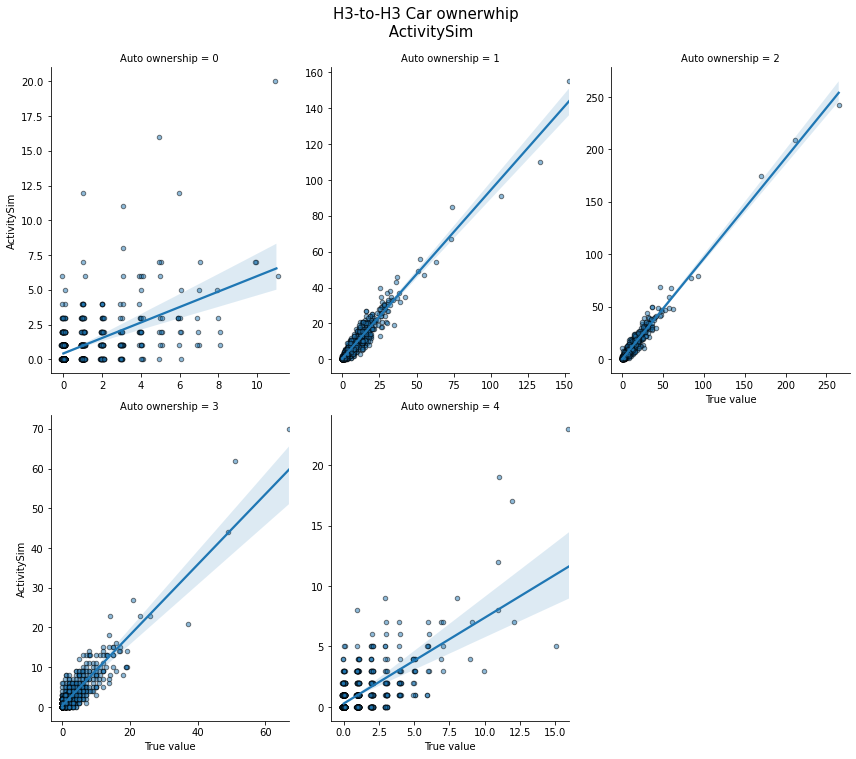

In [108]:
to_plot = car_ownership_validation(hh)

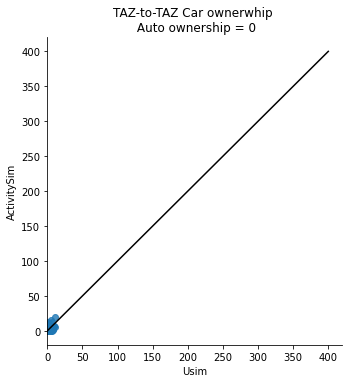

In [109]:
sns.lmplot('True value','ActivitySim',  to_plot[to_plot['Auto ownership']=='0'])

x = np.linspace(0,400,400)
plt.plot(x, x, color = 'black')
plt.title('TAZ-to-TAZ Car ownerwhip \n Auto ownership = 0')
plt.xlabel('Usim');